In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
# 폰트 설정 후 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

c:\Users\Administrator\anaconda3\dev\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
file_path = '../data/최종 데이터셋.csv' 
df = pd.read_csv(file_path, encoding="utf-8")

### 1. 상권별 기본 현황 분석

In [3]:
# ----------------------------------------------------------------------
# 1. 어떤 상권들이 있는지 확인
# ----------------------------------------------------------------------
print("="*50)
print("### 1. 어떤 상권들이 있는지 확인 ###")
print("="*50)

# nunique()로 고유한 상권의 개수를, unique()로 상권 목록을 확인
unique_commercial_areas = df['상권'].unique()
num_unique_commercial_areas = df['상권'].nunique()

print(f"▶ 전체 상권 개수: {num_unique_commercial_areas}개")
print("▶ 전체 상권 목록:")
# 리스트 형태로 출력
print(list(unique_commercial_areas))
print("\n")


# ----------------------------------------------------------------------
# 2. 상권별 가맹점 수 파악
# ----------------------------------------------------------------------
print("="*50)
print("### 2. 상권별 가맹점 수 파악 ###")
print("="*50)

# 상권별 데이터 개수(가맹점 수)를 세고, 내림차순 정렬
commercial_area_counts = df.groupby('상권')['가맹점구분번호'].nunique().reset_index(name = '가맹점수')

print("▶ 상권별 가맹점 수 (내림차순):")
print(commercial_area_counts)
print("\n")


# ----------------------------------------------------------------------
# 3. 상권별 업종 분포 분석
# ----------------------------------------------------------------------
print("="*50)
print("### 3. 상권별 업종 분포 분석 ###")
print("="*50)

# 위에서 확인한 고유 상권 목록(unique_commercial_areas)을 하나씩 순회
for area in unique_commercial_areas:
    print(f"--- {area} 상권의 업종 분포 (Top 5) ---")
    
    # 먼저 전체 데이터프레임(df)에서 해당 상권의 데이터만 필터링
    area_df = df[df['상권'] == area]
    
    # 필터링된 데이터에서 업종별 개수를 세고, 비율(normalize=True)로 변환한 뒤 100을 곱해 퍼센트로 만듦
    # head(5)를 사용해 상위 5개만 선택
    category_distribution = (area_df['업종'].value_counts(normalize=True) * 100).head(5)
    
    # round(1)을 사용해 소수점 첫째 자리까지만 표시
    for category, percentage in category_distribution.items():
        print(f"{category}: {round(percentage, 1)}%")
    print("-" * (len(area) + 30) + "\n")

### 1. 어떤 상권들이 있는지 확인 ###
▶ 전체 상권 개수: 20개
▶ 전체 상권 목록:
['뚝섬', '마장동', '답십리', '성수', '왕십리', '옥수', '금남시장', '한양대', '장한평자동차', '행당', '신금호', '기타', '압구정로데오', '풍산지구', '화양시장', '미아사거리', '방배역', '자양', '동대문역사문화공원역', '건대입구']


### 2. 상권별 가맹점 수 파악 ###
▶ 상권별 가맹점 수 (내림차순):
            상권  가맹점수
0         건대입구     1
1         금남시장   292
2           기타     1
3          답십리   178
4   동대문역사문화공원역     1
5           뚝섬   456
6          마장동   475
7        미아사거리     1
8          방배역     1
9           성수  1075
10         신금호    93
11      압구정로데오     1
12          옥수   187
13         왕십리   834
14          자양     1
15      장한평자동차    42
16        풍산지구     1
17         한양대   320
18          행당    82
19        화양시장     1


### 3. 상권별 업종 분포 분석 ###
--- 뚝섬 상권의 업종 분포 (Top 5) ---
카페: 14.1%
백반/가정식: 9.0%
양식: 8.1%
한식-육류/고기: 8.0%
한식-단품요리일반: 7.3%
--------------------------------

--- 마장동 상권의 업종 분포 (Top 5) ---
축산물: 45.9%
한식-육류/고기: 12.1%
백반/가정식: 5.7%
식료품: 3.9%
카페: 2.9%
---------------------------------

--- 답십리 상권의 업종 분포 (Top 5) ---

### 2. 상권별 고객 인구 통계 분석

In [4]:
demographic_cols = [
    '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중', '남성 50대 고객 비중', '남성 60대이상 고객 비중',
    '여성 20대이하 고객 비중', '여성 30대 고객 비중', '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중'
]
for col in demographic_cols:
    df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

# ----------------------------------------------------------------------
# [핵심 로직 수정] 유사 그룹 함께 찾기
# ----------------------------------------------------------------------
print("="*50)
print("### 2. 상권별 고객 인구 통계 분석 (유사 그룹 포함) ###")
print("="*50)

# 상권별 평균 계산
commercial_area_demographics = df.groupby('상권')[demographic_cols].mean()

# 결과를 저장할 리스트
analysis_results_list = []

# 최댓값과 비교할 허용 오차 (예: 2%p)
THRESHOLD = 2.0

for area, demographics in commercial_area_demographics.iterrows():
    # 1. 해당 상권의 최대 비율 값을 찾는다.
    max_percentage = demographics.max()
    
    # 2. 최대 비율 값과 THRESHOLD 이내에 있는 모든 그룹을 찾는다.
    similar_groups = demographics[demographics >= max_percentage - THRESHOLD]
    
    # 3. 결과를 보기 좋게 문자열로 포맷팅한다.
    #    (예: "여성 20대이하 (22.5%), 여성 30대 (21.8%)")
    result_str = ", ".join([
        f"{group.replace(' 고객 비중', '')} ({percentage:.1f}%)"
        for group, percentage in similar_groups.items()
    ])
    
    analysis_results_list.append({
        '상권': area,
        '핵심 고객층 (유사 그룹 포함)': result_str
    })

# 리스트를 데이터프레임으로 변환
analysis_result_df = pd.DataFrame(analysis_results_list)

print("▶ 상권별 핵심 고객층 분석 결과:")
print(analysis_result_df)

### 2. 상권별 고객 인구 통계 분석 (유사 그룹 포함) ###
▶ 상권별 핵심 고객층 분석 결과:
            상권                                  핵심 고객층 (유사 그룹 포함)
0         건대입구                                     남성 30대 (21.0%)
1         금남시장  남성 30대 (11.3%), 남성 40대 (12.0%), 남성 50대 (13.1%)...
2           기타                                     남성 30대 (22.4%)
3          답십리                                     남성 50대 (15.7%)
4   동대문역사문화공원역                   남성 20대이하 (19.7%), 남성 30대 (19.3%)
5           뚝섬   남성 30대 (16.7%), 여성 20대이하 (16.2%), 여성 30대 (16.2%)
6          마장동                                   남성 60대이상 (17.2%)
7        미아사거리                     남성 50대 (33.0%), 여성 50대 (34.9%)
8          방배역                   여성 20대이하 (27.6%), 여성 30대 (26.0%)
9           성수                                     남성 30대 (15.9%)
10         신금호                     남성 40대 (11.7%), 남성 50대 (13.6%)
11      압구정로데오                                     여성 50대 (74.5%)
12          옥수  남성 30대 (12.9%), 남성 40대 (11.6%), 여성 30대 (13.0%)...
13         왕십리    

### 3. 상권별 고객 행동 패턴 분석

### 데이터 전처리 완료: 행동 패턴 컬럼의 음수 값을 결측치로 처리했습니다. ###

### 3. 상권별 고객 행동 패턴 분석 ###
▶ 상권별 평균 고객 행동 패턴 분석 결과:
            재방문 고객 비중  신규 고객 비중  거주 이용 고객 비율  직장 이용 고객 비율  유동인구 이용 고객 비율
상권                                                                      
건대입구             32.3       7.4          7.7         36.4           55.8
금남시장             27.2       9.0         59.3          5.1           35.5
기타               18.1       6.0         28.7          9.6           61.7
답십리              27.6      10.1         35.3         12.5           52.2
동대문역사문화공원역       15.0      14.3          3.5          3.3           93.3
뚝섬               22.8      11.3         21.0         21.6           57.3
마장동              25.4       9.3         29.0          8.0           63.0
미아사거리             0.0      28.5          0.0          0.0          100.0
방배역              23.4       8.2          1.4          1.6           97.0
성수               24.3      10.2         22.5         19.8           57.6
신금호              32.7 

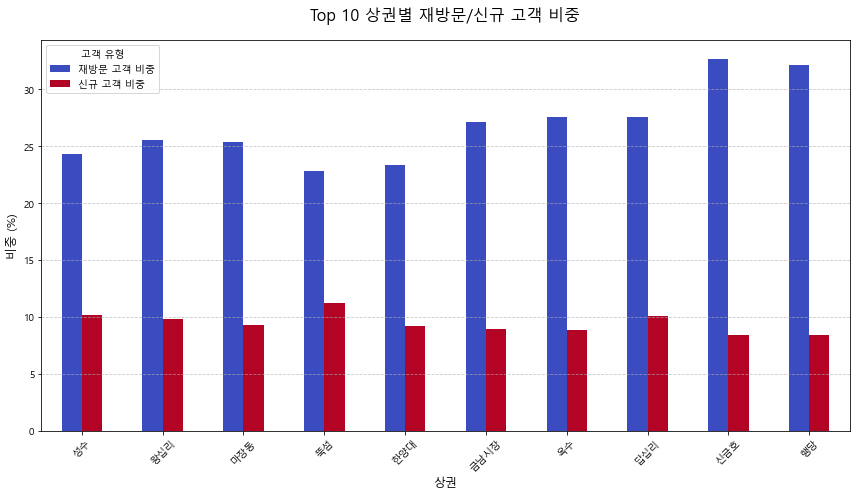

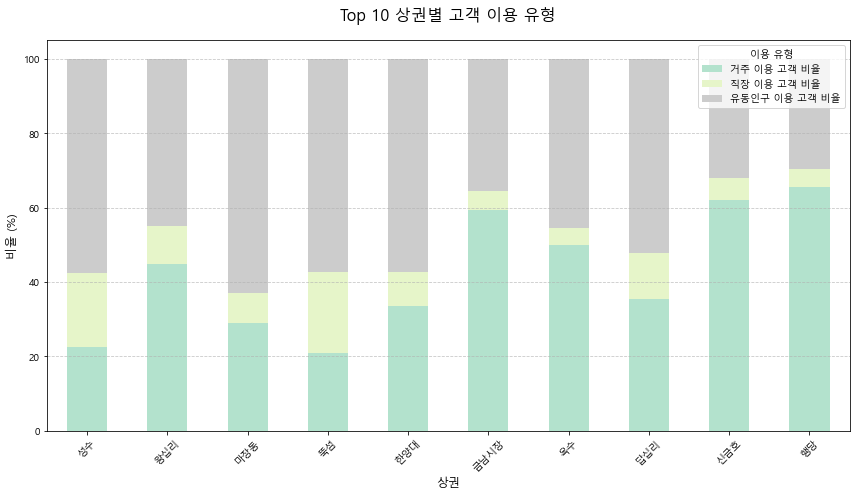

In [5]:
# ----------------------------------------------------------------------
# [데이터 전처리] 분석할 컬럼들의 음수 값을 결측치(NaN)로 변경
# ----------------------------------------------------------------------
behavior_cols = [
    '재방문 고객 비중', '신규 고객 비중',
    '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율'
]

# behavior_cols에 포함된 컬럼들에서 0보다 작은 값(음수)을 np.nan (결측치)으로 변경
for col in behavior_cols:
    df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

print("### 데이터 전처리 완료: 행동 패턴 컬럼의 음수 값을 결측치로 처리했습니다. ###\n")

# ----------------------------------------------------------------------
# 3. 상권별 고객 행동 패턴 분석
# ----------------------------------------------------------------------
print("="*50)
print("### 3. 상권별 고객 행동 패턴 분석 ###")
print("="*50)

# '상권'을 기준으로 그룹화하고, 각 행동 패턴 컬럼의 평균을 계산
# 이 평균값은 해당 상권의 평균적인 고객 행동 패턴을 나타냄
commercial_area_behavior = df.groupby('상권')[behavior_cols].mean()

# 분석 결과를 소수점 첫째 자리까지 반올림하여 출력
print("▶ 상권별 평균 고객 행동 패턴 분석 결과:")
print(commercial_area_behavior.round(1))


# ----------------------------------------------------------------------
# [시각화 1] Top 10 상권별 재방문/신규 고객 비중
# ----------------------------------------------------------------------
# 가맹점 수 기준 상위 10개 상권의 이름만 가져옴
top_10_areas = df['상권'].value_counts().head(10).index
top_10_behavior = commercial_area_behavior.loc[top_10_areas]

# 재방문/신규 고객 비중만 선택하여 시각화
top_10_behavior[['재방문 고객 비중', '신규 고객 비중']].plot(
    kind='bar',
    figsize=(12, 7),
    rot=45,
    colormap='coolwarm'
)
plt.title('Top 10 상권별 재방문/신규 고객 비중', fontsize=16, pad=20)
plt.xlabel('상권', fontsize=12)
plt.ylabel('비중 (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='고객 유형')
plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------
# [시각화 2] Top 10 상권별 고객 이용 유형 (상권 특성 파악)
# ----------------------------------------------------------------------
# 거주/직장/유동인구 이용 비율만 선택하여 누적 막대그래프로 시각화
top_10_behavior[['거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율']].plot(
    kind='bar',
    figsize=(12, 7),
    stacked=True, # 누적 막대그래프 옵션
    rot=45,
    colormap='Pastel2'
)
plt.title('Top 10 상권별 고객 이용 유형', fontsize=16, pad=20)
plt.xlabel('상권', fontsize=12)
plt.ylabel('비율 (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='이용 유형')
plt.tight_layout()
plt.show()

## 위 분석 결과를 정리한 데이터셋 만들기

In [6]:
# 분석에 사용할 모든 컬럼을 정의하고, 음수 값을 결측치(NaN)로 변경
analysis_cols = [
    '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중', '남성 50대 고객 비중', '남성 60대이상 고객 비중',
    '여성 20대이하 고객 비중', '여성 30대 고객 비중', '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중',
    '재방문 고객 비중', '신규 고객 비중',
    '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율'
]
for col in analysis_cols:
    df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

print("### 데이터 로딩 및 전처리 완료 ###\n")


# ----------------------------------------------------------------------
# [분석] 모든 분석을 미리 계산
# ----------------------------------------------------------------------
# 1. 상권별 업종 분포
commercial_area_categories = df.groupby('상권')['업종'].apply(lambda x: x.value_counts().head(5))

# 2. 상권별 고객 인구 통계 (연령/성별 컬럼만 명확하게 지정)
demographic_cols = [
    '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중', '남성 50대 고객 비중', '남성 60대이상 고객 비중',
    '여성 20대이하 고객 비중', '여성 30대 고객 비중', '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중'
]
commercial_area_demographics = df.groupby('상권')[demographic_cols].mean()

# 3. 상권별 고객 행동 패턴
behavior_cols = [col for col in analysis_cols if '고객 비율' in col]
commercial_area_behavior = df.groupby('상권')[behavior_cols].mean()

# 4. 상권별 고객 방문 패턴 (재방문/신규)
retention_cols = ['재방문 고객 비중', '신규 고객 비중']
commercial_area_retention = df.groupby('상권')[retention_cols].mean()

# ----------------------------------------------------------------------
# [상권 분석 결과 데이터셋 생성]
# ----------------------------------------------------------------------
data = []
# 최댓값과 비교할 허용 오차 (예: 2%p)
THRESHOLD = 2.0

# 모든 고유 상권 목록을 가져와 하나씩 처리
for area in df['상권'].unique():
    if area not in commercial_area_demographics.index: continue
    
    # 1. 핵심 고객층 찾기 (유사 그룹 모두 포함)
    demographics = commercial_area_demographics.loc[area]
    max_percentage = demographics.max()
    similar_groups = demographics[demographics >= max_percentage - THRESHOLD]
    
    # '핵심_고객층' 컬럼에 들어갈 상세 정보 문자열 생성
    core_customer_info = ", ".join([
        f"{group.replace(' 고객 비중', '')} ({percentage:.1f}%)"
        for group, percentage in similar_groups.items()
    ])
    
    core_group_names_list = [group.replace(' 고객 비중', '') for group in similar_groups.index]
    core_customer_summary_str = ", ".join(core_group_names_list)

    # 2. 상권 유형 찾기
    area_type_series = commercial_area_behavior.loc[area, ['거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율']].idxmax()
    area_type_percentage = commercial_area_behavior.loc[area, ['거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율']].max()
    area_type_info = f"{area_type_series.replace(' 이용 고객 비율', '')} 중심 ({area_type_percentage:.1f}%)"

    # 3. 주요 업종 Top 5 가져오기
    top_5_categories = ", ".join(commercial_area_categories.loc[area].index.tolist())

    # 4. 고객 방문 패턴 (재방문/신규) 가져오기
    retention_stats = commercial_area_retention.loc[area]
    revisit_rate = retention_stats['재방문 고객 비중']
    new_rate = retention_stats['신규 고객 비중']

    # 요약 문장에 사용할 텍스트 생성
    if revisit_rate > new_rate:
        retention_summary = f"재방문 고객({revisit_rate:.1f}%) 비중이 높은"
    else:
        retention_summary = f"신규 고객({new_rate:.1f}%) 유입이 활발한"

    # 5. 특징 요약 문장 생성
    summary = (
        f"{core_customer_summary_str}이(가) 주로 찾는 "
        f"{area_type_series.replace(' 이용 고객 비율', '')} 중심의 상권으로, "
        f"{retention_summary} 곳이며, "  
        f"주로 {top_5_categories.split(',')[0]} 업종이 발달해 있습니다."
    )

    # 6. 결과 리스트에 추가
    data.append({
        '상권명': area,
        '특징_요약': summary,
        '핵심_고객층': core_customer_info,
        '상권_유형': area_type_info,
        '주요_업종_Top5': top_5_categories,
        '평균_재방문율(%)': round(revisit_rate, 2), # <-- 추가된 컬럼
        '평균_신규방문율(%)': round(new_rate, 2)  # <-- 추가된 컬럼
    })

# 리스트를 데이터프레임으로 변환
commercial_area_df = pd.DataFrame(data)

# 5. CSV 파일로 저장
output_dir = '../data'
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, '상권별_특징분석결과_리스트.csv')
commercial_area_df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"### 상권 분석 결과 데이터셋 생성 완료! ###")
print(f"'{output_filename}' 경로에 파일이 저장되었습니다.")
print("\n[생성된 데이터셋 미리보기]")
print(commercial_area_df.head())

### 데이터 로딩 및 전처리 완료 ###

### 상권 분석 결과 데이터셋 생성 완료! ###
'../data\상권별_특징분석결과_리스트.csv' 경로에 파일이 저장되었습니다.

[생성된 데이터셋 미리보기]
   상권명                                              특징_요약  \
0   뚝섬  남성 30대, 여성 20대이하, 여성 30대이(가) 주로 찾는 유동인구 중심의 상권...   
1  마장동  남성 60대이상이(가) 주로 찾는 유동인구 중심의 상권으로, 재방문 고객(25.4%...   
2  답십리  남성 50대이(가) 주로 찾는 유동인구 중심의 상권으로, 재방문 고객(27.6%) ...   
3   성수  남성 30대이(가) 주로 찾는 유동인구 중심의 상권으로, 재방문 고객(24.3%) ...   
4  왕십리  남성 30대, 남성 50대이(가) 주로 찾는 유동인구 중심의 상권으로, 재방문 고객...   

                                             핵심_고객층            상권_유형  \
0  남성 30대 (16.7%), 여성 20대이하 (16.2%), 여성 30대 (16.2%)  유동인구 중심 (57.3%)   
1                                  남성 60대이상 (17.2%)  유동인구 중심 (63.0%)   
2                                    남성 50대 (15.7%)  유동인구 중심 (52.2%)   
3                                    남성 30대 (15.9%)  유동인구 중심 (57.6%)   
4                    남성 30대 (12.8%), 남성 50대 (13.5%)  유동인구 중심 (44.9%)   

                                   주요_업종_Top5  평균_재방문율(%)  평균_신규방문율(%)  
0         

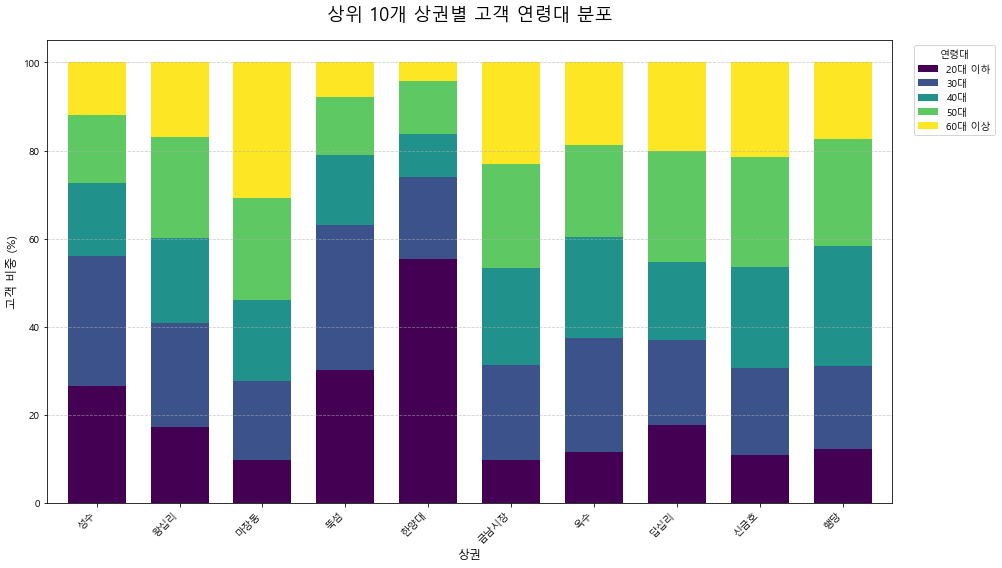

In [7]:
# 분석에 사용할 인구 통계 컬럼들을 리스트로 정의
demographic_cols = [
    '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중', '남성 50대 고객 비중', '남성 60대이상 고객 비중',
    '여성 20대이하 고객 비중', '여성 30대 고객 비중', '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중'
]

# demographic_cols에 포함된 컬럼들에서 0보다 작은 값(음수)을 np.nan (결측치)으로 변경
for col in demographic_cols:
    df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

# ----------------------------------------------------------------------
# [데이터 가공] 연령대별 데이터 합산
# ----------------------------------------------------------------------
# 남성/여성으로 나뉜 데이터를 연령대별로 합산하여 새로운 컬럼을 만듦
df['20대 이하'] = df['남성 20대이하 고객 비중'] + df['여성 20대이하 고객 비중']
df['30대'] = df['남성 30대 고객 비중'] + df['여성 30대 고객 비중']
df['40대'] = df['남성 40대 고객 비중'] + df['여성 40대 고객 비중']
df['50대'] = df['남성 50대 고객 비중'] + df['여성 50대 고객 비중']
df['60대 이상'] = df['남성 60대이상 고객 비중'] + df['여성 60대이상 고객 비중']

age_groups = ['20대 이하', '30대', '40대', '50대', '60대 이상']

# 상권별로 연령대 그룹의 평균을 계산
commercial_area_age_dist = df.groupby('상권')[age_groups].mean()

top_10_areas = df['상권'].value_counts().head(10).index
top_10_age_dist = commercial_area_age_dist.loc[top_10_areas]


# ----------------------------------------------------------------------
# [시각화] 누적 막대그래프 생성
# ----------------------------------------------------------------------
top_10_age_dist.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='viridis', # 색상 팔레트 지정
    width=0.7
)

plt.title('상위 10개 상권별 고객 연령대 분포', fontsize=18, pad=20)
plt.xlabel('상권', fontsize=12)
plt.ylabel('고객 비중 (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # x축 라벨 회전
plt.legend(title='연령대', bbox_to_anchor=(1.02, 1), loc='upper left') # 범례를 그래프 밖에 표시
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout() # 그래프 요소들이 겹치지 않게 조정
plt.show()

## 상권별 업종 및 매출 분석

In [8]:
# 상권별 업종 분포 분석
print("="*50)
print("### 상권별 업종 분포 분석 ###")
print("="*50)

# 위에서 확인한 고유 상권 목록(unique_commercial_areas)을 하나씩 순회
for area in unique_commercial_areas:
    print(f"--- {area} 상권의 업종 분포 (Top 5) ---")
    
    # 먼저 전체 데이터프레임(df)에서 해당 상권의 데이터만 필터링
    area_df = df[df['상권'] == area]
    
    # 필터링된 데이터에서 업종별 개수를 세고, 비율(normalize=True)로 변환한 뒤 100을 곱해 퍼센트로 만듦
    # head(5)를 사용해 상위 5개만 선택
    category_distribution = (area_df['업종'].value_counts(normalize=True) * 100).head(5)
    
    # round(1)을 사용해 소수점 첫째 자리까지만 표시
    for category, percentage in category_distribution.items():
        print(f"{category}: {round(percentage, 1)}%")
    print("-" * (len(area) + 30) + "\n")

### 상권별 업종 분포 분석 ###
--- 뚝섬 상권의 업종 분포 (Top 5) ---
카페: 14.1%
백반/가정식: 9.0%
양식: 8.1%
한식-육류/고기: 8.0%
한식-단품요리일반: 7.3%
--------------------------------

--- 마장동 상권의 업종 분포 (Top 5) ---
축산물: 45.9%
한식-육류/고기: 12.1%
백반/가정식: 5.7%
식료품: 3.9%
카페: 2.9%
---------------------------------

--- 답십리 상권의 업종 분포 (Top 5) ---
한식-육류/고기: 14.5%
백반/가정식: 9.3%
한식-단품요리일반: 8.7%
한식-해물/생선: 7.1%
농산물: 5.6%
---------------------------------

--- 성수 상권의 업종 분포 (Top 5) ---
백반/가정식: 10.9%
카페: 10.4%
한식-육류/고기: 9.1%
한식-단품요리일반: 8.0%
양식: 6.1%
--------------------------------

--- 왕십리 상권의 업종 분포 (Top 5) ---
한식-육류/고기: 12.9%
백반/가정식: 8.5%
한식-단품요리일반: 7.4%
카페: 6.1%
치킨: 4.3%
---------------------------------

--- 옥수 상권의 업종 분포 (Top 5) ---
카페: 9.7%
한식-육류/고기: 9.5%
백반/가정식: 9.4%
베이커리: 6.6%
양식: 5.5%
--------------------------------

--- 금남시장 상권의 업종 분포 (Top 5) ---
한식-육류/고기: 10.8%
백반/가정식: 8.2%
한식-단품요리일반: 7.6%
카페: 6.3%
치킨: 5.6%
----------------------------------

--- 한양대 상권의 업종 분포 (Top 5) ---
한식-육류/고기: 15.3%
한식-단품요리일반: 12.4%
카페: 7.7%
백반/가정식: 5.7%
커피전문

In [9]:
# 상권 및 업종별로 그룹화
analysis_all = df.groupby(['상권', '업종']).agg(
    가맹점수=('가맹점구분번호', 'nunique'),      # 가맹점 수 (고유한 값 기준)
    평균매출금액등급=('매출금액 구간', 'mean'),   # 평균 매출금액 등급
    평균매출건수등급=('매출건수 구간', 'mean')    # 평균 매출건수 등급
).reset_index()

analysis_all['평균매출금액등급'] = analysis_all['평균매출금액등급'].round(2)
analysis_all['평균매출건수등급'] = analysis_all['평균매출건수등급'].round(2)

# 결과를 상권별, 그리고 가맹점수 순으로 정렬
analysis_all_sorted = analysis_all.sort_values(by=['상권', '가맹점수'], ascending=[True, False])

# 결과 출력 및 저장
print("## 상권별 전체 업종 분석 결과 확인 ##")
print(analysis_all_sorted.head(10))
output_filename = "../data/상권_업종별_평균매출분석.csv"
analysis_all_sorted.to_csv(output_filename, index=False, encoding='utf-8-sig')

## 상권별 전체 업종 분석 결과 확인 ##
      상권         업종  가맹점수  평균매출금액등급  평균매출건수등급
0   건대입구   동남아/인도음식     1      3.42      3.00
44  금남시장   한식-육류/고기    31      3.28      3.94
12  금남시장     백반/가정식    23      4.24      4.19
43  금남시장  한식-단품요리일반    23      4.68      4.53
34  금남시장         카페    17      4.28      3.45
33  금남시장         치킨    16      3.78      3.65
17  금남시장        식료품    13      4.67      4.39
47  금남시장   한식-해물/생선    12      3.53      3.94
20  금남시장         양식    10      3.75      4.26
13  금남시장       베이커리     9      3.63      2.55


In [10]:
# 상권별 매출
analysis_all_region = df.groupby(['상권']).agg(
    가맹점수=('가맹점구분번호', 'nunique'),      # 가맹점 수 (고유한 값 기준)
    평균매출금액등급=('매출금액 구간', 'mean'),   # 평균 매출금액 등급
    평균매출건수등급=('매출건수 구간', 'mean')    # 평균 매출건수 등급
).reset_index()

analysis_all_region['평균매출금액등급'] = analysis_all_region['평균매출금액등급'].round(2)
analysis_all_region['평균매출건수등급'] = analysis_all_region['평균매출건수등급'].round(2)

# 결과를 상권별, 그리고 가맹점수 순으로 정렬
analysis_all_sorted = analysis_all_region.sort_values(by=['상권', '가맹점수'], ascending=[True, False])

# 결과 출력 및 저장
print("## 상권별 전체 업종 분석 결과 확인 ##")
print(analysis_all_sorted.head(10))
output_filename = "../data/상권별_평균매출분석.csv"
analysis_all_sorted.to_csv(output_filename, index=False, encoding='utf-8-sig')

## 상권별 전체 업종 분석 결과 확인 ##
           상권  가맹점수  평균매출금액등급  평균매출건수등급
0        건대입구     1      3.42      3.00
1        금남시장   292      3.90      3.80
2          기타     1      3.54      3.88
3         답십리   178      3.52      3.47
4  동대문역사문화공원역     1      5.08      4.71
5          뚝섬   456      3.13      3.05
6         마장동   475      4.03      4.38
7       미아사거리     1      5.91      5.55
8         방배역     1      5.08      4.29
9          성수  1075      3.36      3.31


## 2. 상권 및 업종별 매출 등급 분포 분석

In [11]:
# 상권, 업종, 매출금액 구간별로 가맹점 수 계산
analysis_2 = df.groupby(['상권', '업종', '매출금액 구간']).size().unstack(fill_value=0)

# 각 그룹(상권-업종)의 전체 가맹점 수 계산
total_counts = analysis_2.sum(axis=1)

# 각 매출 등급의 비율 계산
# (각 등급의 가게 수) / (그 시장의 전체 가게 수) * 100
# 예시: '성수-카페'의 1등급 비율 -> 10 / 100 * 100 = 10%
analysis_2_ratio = analysis_2.divide(total_counts, axis=0) * 100
analysis_2_ratio = analysis_2_ratio.round(2) # 소수점 2자리까지 반올림

# 결과 출력 및 저장
print("\n## 상권_업종별_매출등급분포(%) ##")
print(analysis_2_ratio.head())

analysis_2_ratio.to_csv("../data/상권_업종별_매출등급_분포.csv", encoding='utf-8-sig')


## 상권_업종별_매출등급분포(%) ##
매출금액 구간           1     2      3      4      5      6
상권   업종                                              
건대입구 동남아/인도음식  0.00  4.17  50.00  45.83   0.00   0.00
금남시장 건강식품      0.00  0.00   0.00   6.12  67.35  26.53
     건강원       0.00  0.00   0.00   3.33  80.00  16.67
     건어물       2.08  2.08  47.92  35.42  12.50   0.00
     농산물       0.00  0.00   8.67  29.48  37.57  24.28


In [12]:
# 상권, 매출금액 구간별로 가맹점 수 계산
analysis_region_2 = df.groupby(['상권', '매출금액 구간']).size().unstack(fill_value=0)

# 각 그룹(상권-업종)의 전체 가맹점 수 계산
total_counts = analysis_region_2.sum(axis=1)

analysis_region_2 = analysis_region_2.divide(total_counts, axis=0) * 100
analysis_region_2 = analysis_region_2.round(2) # 소수점 2자리까지 반올림

# 결과 출력 및 저장
print("\n## 상권별_매출등급분포(%) ##")
print(analysis_region_2.head())

analysis_region_2.to_csv("../data/상권별_매출등급_분포.csv", encoding='utf-8-sig')


## 상권별_매출등급분포(%) ##
매출금액 구간        1      2      3      4      5     6
상권                                                
건대입구        0.00   4.17  50.00  45.83   0.00  0.00
금남시장        3.57   8.79  23.28  32.07  23.28  9.00
기타          0.00   4.17  45.83  41.67   8.33  0.00
답십리         6.76  14.88  25.67  30.12  17.74  4.84
동대문역사문화공원역  0.00   0.00   0.00   0.00  91.67  8.33


In [13]:
analysis_2

매출금액 구간         1   2   3   4   5   6
상권   업종                              
건대입구 동남아/인도음식   0   1  12  11   0   0
금남시장 건강식품       0   0   0   3  33  13
     건강원        0   0   0   1  24   5
     건어물        1   1  23  17   6   0
     농산물        0   0  15  51  65  42
...            ..  ..  ..  ..  ..  ..
행당   한식-육류/고기  27  21   0  22   2   0
     한식-찌개/전골   0   0   0   0   8  16
     한식-해물/생선   0   0   0   2  20   2
     햄버거        0   1   2   0   0   1
화양시장 백반/가정식     0   0   1  21   2   0

[468 rows x 6 columns]

In [14]:
total_counts

상권    업종      
건대입구  동남아/인도음식     24
금남시장  건강식품         49
      건강원          30
      건어물          48
      농산물         173
                 ... 
행당    한식-육류/고기     72
      한식-찌개/전골     24
      한식-해물/생선     24
      햄버거           4
화양시장  백반/가정식       24
Length: 468, dtype: int64

## 3. 상권 및 업종별 경쟁 강도 및 시장성 분석

▼ 가맹점 수(경쟁 강도) 핵심 통계량
count    466.000000
mean       8.675966
std       17.410420
min        1.000000
25%        1.000000
50%        3.000000
75%        9.000000
max      212.000000
Name: 가맹점수, dtype: float64


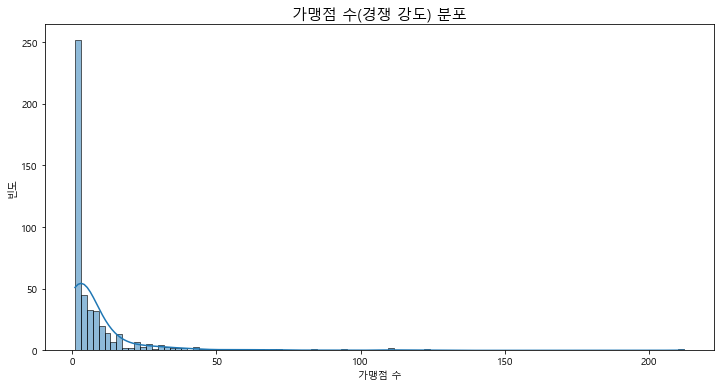

In [13]:
# 경쟁 강도(가맹점수) 분포 확인

file_path = '../data/상권_업종별_평균매출분석.csv'
count_df = pd.read_csv(file_path)

# 핵심 통계량 출력
print("▼ 가맹점 수(경쟁 강도) 핵심 통계량")
print(count_df['가맹점수'].describe())

# 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(data=count_df, x='가맹점수', kde=True)
plt.title('가맹점 수(경쟁 강도) 분포', fontsize=15)
plt.xlabel('가맹점 수')
plt.ylabel('빈도')
plt.show()

In [14]:
# 상권및업종별
file_path = '../data/상권_업종별_평균매출분석.csv'
df = pd.read_csv(file_path)

count_1 = df[df['가맹점수'] == 1].shape[0]
count_2_9 = df[(df['가맹점수'] >= 2) & (df['가맹점수'] <= 9)].shape[0]
count_10_29 = df[(df['가맹점수'] >= 10) & (df['가맹점수'] <= 29)].shape[0]
count_30_49 = df[(df['가맹점수'] >= 30) & (df['가맹점수'] <= 49)].shape[0]
count_50_plus = df[df['가맹점수'] >= 50].shape[0]

print("▼ 경쟁 강도(가맹점 수) 구간별 시장 개수")
print("="*40)
print(f"       1개 시장 : {count_1}개")
print(f"  2개 ~ 9개 시장 : {count_2_9}개")
print(f" 10개 ~ 29개 시장 : {count_10_29}개")
print(f" 30개 ~ 49개 시장 : {count_30_49}개")
print(f"    50개 이상 시장 : {count_50_plus}개")
print("="*40)
print(f"         총 합계 : {count_1 + count_2_9 + count_10_29 + count_30_49 + count_50_plus}개")

▼ 경쟁 강도(가맹점 수) 구간별 시장 개수
       1개 시장 : 132개
  2개 ~ 9개 시장 : 230개
 10개 ~ 29개 시장 : 74개
 30개 ~ 49개 시장 : 17개
    50개 이상 시장 : 13개
         총 합계 : 466개


In [15]:
# 상권별
file_path = '../data/상권_업종별_평균매출분석.csv'
df = pd.read_csv(file_path)

def classify_competition_final(num_stores):
    if num_stores >= 50:
        return '포화'
    elif num_stores >= 30:
        return '매우 강함'
    elif num_stores >= 10:
        return '강함'
    elif num_stores >= 2:
        return '보통'
    else:
        return '약함'

df['경쟁강도_등급'] = df['가맹점수'].apply(classify_competition_final)

output_file = '..\data\상권_업종별_평균매출_경쟁강도_분석.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')


# 검증용
print(df['경쟁강도_등급'].value_counts())

보통       230
약함       132
강함        74
매우 강함     17
포화        13
Name: 경쟁강도_등급, dtype: int64


In [16]:
file_path = '../data/상권별_평균매출분석.csv'
df = pd.read_csv(file_path)

# 2. '가맹점수' 컬럼의 분포를 통계적으로 확인합니다.
print("▼ '가맹점수' 컬럼의 핵심 통계량")
# describe()의 백분위수를 더 자세하게 봅니다. (90%, 95% 추가)
print(df['가맹점수'].describe(percentiles=[.25, .5, .75, .90, .95]))


# 3. 통계치를 기반으로 '경쟁 강도' 기준점을 설정합니다.
# quantile() 함수는 데이터의 특정 % 지점의 값을 알려줍니다.
q1 = df['가맹점수'].quantile(0.25)  # 하위 25% 지점
q3 = df['가맹점수'].quantile(0.75)  # 상위 25% 지점
q95 = df['가맹점수'].quantile(0.95) # 상위 5% 지점

print("\n▼ 설정된 경쟁 강도 기준점")
print(f"  - 약함/보통 경계 (하위 25%): {q1}개")
print(f"  - 보통/강함 경계 (상위 25%): {q3}개")
print(f"  - 강함/포화 경계 (상위 5%): {q95}개")

# 4. 4단계 분류 함수를 정의합니다.
def classify_competition_4levels(num_stores):
    if num_stores > q95:
        return '포화'
    elif num_stores > q3:
        return '강함'
    elif num_stores > q1:
        return '보통'
    else:
        return '약함'

# 5. 함수를 적용하여 '경쟁강도_등급' 컬럼을 생성합니다.
df['경쟁강도_등급'] = df['가맹점수'].apply(classify_competition_4levels)

# 6. 최종 결과물 확인 및 저장
print("\n▼ 최종 등급 적용 결과 (상위 10개)")
print(df.sort_values(by='가맹점수', ascending=False).head(10))

output_file = '..\data\상권별_경쟁강도_분석.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"\n'{output_file}' 파일이 저장되었습니다!")

# 7. 각 등급별 개수 확인 (검증용)
print("\n▼ 최종 등급별 시장 개수")
print(df['경쟁강도_등급'].value_counts())

▼ '가맹점수' 컬럼의 핵심 통계량
count      20.000000
mean      202.150000
std       302.525558
min         1.000000
25%         1.000000
50%        62.000000
75%       299.000000
90%       510.900000
95%       846.050000
max      1075.000000
Name: 가맹점수, dtype: float64

▼ 설정된 경쟁 강도 기준점
  - 약함/보통 경계 (하위 25%): 1.0개
  - 보통/강함 경계 (상위 25%): 299.0개
  - 강함/포화 경계 (상위 5%): 846.0500000000002개

▼ 최종 등급 적용 결과 (상위 10개)
      상권  가맹점수  평균매출금액등급  평균매출건수등급 경쟁강도_등급
9     성수  1075      3.36      3.31      포화
13   왕십리   834      3.47      3.47      강함
6    마장동   475      4.03      4.38      강함
5     뚝섬   456      3.13      3.05      강함
17   한양대   320      2.80      2.77      강함
1   금남시장   292      3.90      3.80      보통
12    옥수   187      3.61      3.57      보통
3    답십리   178      3.52      3.47      보통
10   신금호    93      3.67      3.36      보통
18    행당    82      3.73      3.16      보통

'..\data\상권별_경쟁강도_분석.csv' 파일이 저장되었습니다!

▼ 최종 등급별 시장 개수
약함    9
보통    6
강함    4
포화    1
Name: 경쟁강도_등급, dtype: int64


## 상권별 매출 및 경쟁강도 리스트

In [17]:
# ----------------------------------------------------------------------
# [공통] 1. 원본 데이터 로딩 및 저장 경로 설정
# ----------------------------------------------------------------------
# (오류 방지를 위해 원본 데이터를 'df_raw'라는 새 변수로 다시 불러옵니다)
try:
    df_raw = pd.read_csv('..\data\최종 데이터셋.csv')
except FileNotFoundError:
    print("ERROR: '최종 데이터셋.csv' 원본 파일을 찾을 수 없습니다.")
    # 이 셀의 나머지 부분은 실행하지 않음 (오류 발생)
    raise

# 최종 파일 저장 경로
output_dir = '../data'
os.makedirs(output_dir, exist_ok=True)

print("### 원본 데이터 로딩 완료 ###\n")

# ----------------------------------------------------------------------
# [분석 1] '상권_업종별' 분석 리스트 생성
# ----------------------------------------------------------------------
print("="*50)
print("### [분석 1] '상권_업종별' 분석 리스트 생성 중... ###")

# 1-1. 평균 매출 및 가맹점 수 계산
df_market_sales = df_raw.groupby(['상권', '업종']).agg(
    가맹점수=('가맹점구분번호', 'nunique'),
    평균매출금액등급=('매출금액 구간', 'mean'),
    평균매출건수등급=('매출건수 구간', 'mean')
).reset_index()
df_market_sales['평균매출금액등급'] = df_market_sales['평균매출금액등급'].round(2)
df_market_sales['평균매출건수등급'] = df_market_sales['평균매출건수등급'].round(2)

# 1-2. 매출 등급 분포(%) 계산
df_market_dist = df_raw.groupby(['상권', '업종', '매출금액 구간']).size().unstack(fill_value=0)
total_counts_market = df_market_dist.sum(axis=1)
df_market_dist_ratio = df_market_dist.divide(total_counts_market, axis=0) * 100
df_market_dist_ratio = df_market_dist_ratio.round(2)
# 컬럼 이름 변경 (예: 1 -> '매출등급_1_%')
df_market_dist_ratio.columns = [f'매출등급_{col}_%' for col in df_market_dist_ratio.columns]
df_market_dist_ratio = df_market_dist_ratio.reset_index()

# 1-3. 경쟁 강도 등급 (5단계) 계산
def classify_competition_final(num_stores):
    if num_stores >= 50: return '포화'
    elif num_stores >= 30: return '매우 강함'
    elif num_stores >= 10: return '강함'
    elif num_stores >= 2: return '보통'
    else: return '약함'
    
# (1-1에서 계산한 가맹점수 재활용)
df_market_comp = df_market_sales[['상권', '업종', '가맹점수']].copy()
df_market_comp['경쟁강도_등급'] = df_market_comp['가맹점수'].apply(classify_competition_final)

# 1-4. 모든 '상권_업종별' 데이터 병합
final_market_df = pd.merge(df_market_sales, df_market_comp.drop('가맹점수', axis=1), on=['상권', '업종'])
final_market_df = pd.merge(final_market_df, df_market_dist_ratio, on=['상권', '업종'])

# 1-5. 최종 저장
output_file_market = os.path.join(output_dir, '..\data\상권_업종별_매출_경쟁강도_분석결과리스트.csv')
final_market_df = final_market_df.sort_values(by=['상권', '가맹점수'], ascending=[True, False])
final_market_df.to_csv(output_file_market, index=False, encoding='utf-8-sig')

print(f"▶▶▶ '상권_업종별' 분석 완료! '{output_file_market}' 저장 성공")


# ----------------------------------------------------------------------
# [분석 2] '상권별' 분석 리스트 생성
# ----------------------------------------------------------------------
print("\n" + "="*50)
print("### [분석 2] '상권별' 분석 리스트 생성 중... ###")

# 2-1. 평균 매출 및 가맹점 수 계산
df_area_sales = df_raw.groupby(['상권']).agg(
    가맹점수=('가맹점구분번호', 'nunique'),
    평균매출금액등급=('매출금액 구간', 'mean'),
    평균매출건수등급=('매출건수 구간', 'mean')
).reset_index()
df_area_sales['평균매출금액등급'] = df_area_sales['평균매출금액등급'].round(2)
df_area_sales['평균매출건수등급'] = df_area_sales['평균매출건수등급'].round(2)

# 2-2. 매출 등급 분포(%) 계산
df_area_dist = df_raw.groupby(['상권', '매출금액 구간']).size().unstack(fill_value=0)
total_counts_area = df_area_dist.sum(axis=1)
df_area_dist_ratio = df_area_dist.divide(total_counts_area, axis=0) * 100
df_area_dist_ratio = df_area_dist_ratio.round(2)
# 컬럼 이름 변경 (예: 1 -> '매출등급_1_%')
df_area_dist_ratio.columns = [f'매출등급_{col}_%' for col in df_area_dist_ratio.columns]
df_area_dist_ratio = df_area_dist_ratio.reset_index()

# 2-3. 경쟁 강도 등급 (4단계 - 통계 기반) 계산
df_area_comp = df_area_sales[['상권', '가맹점수']].copy()
q1 = df_area_comp['가맹점수'].quantile(0.25)
q3 = df_area_comp['가맹점수'].quantile(0.75)
q95 = df_area_comp['가맹점수'].quantile(0.95)

def classify_competition_4levels(num_stores):
    if num_stores > q95: return '매우강함'
    elif num_stores > q3: return '강함'
    elif num_stores > q1: return '보통'
    else: return '약함'

df_area_comp['경쟁강도_등급'] = df_area_comp['가맹점수'].apply(classify_competition_4levels)

# 2-4. 모든 '상권별' 데이터 병합
final_area_df = pd.merge(df_area_sales, df_area_comp.drop('가맹점수', axis=1), on='상권')
final_area_df = pd.merge(final_area_df, df_area_dist_ratio, on='상권')

# 2-5. 최종 저장
output_file_area = os.path.join(output_dir, '..\data\상권별_매출_경쟁강도_분석결과리스트.csv')
final_area_df = final_area_df.sort_values(by=['가맹점수'], ascending=False)
final_area_df.to_csv(output_file_area, index=False, encoding='utf-8-sig')

print(f"▶▶▶ '상권별' 분석 완료! '{output_file_area}' 저장 성공")
print("\n" + "="*50)
print("### 모든 작업이 완료되었습니다. ###")

### 원본 데이터 로딩 완료 ###

### [분석 1] '상권_업종별' 분석 리스트 생성 중... ###
▶▶▶ '상권_업종별' 분석 완료! '../data\..\data\상권_업종별_매출_경쟁강도_분석결과리스트.csv' 저장 성공

### [분석 2] '상권별' 분석 리스트 생성 중... ###
▶▶▶ '상권별' 분석 완료! '../data\..\data\상권별_매출_경쟁강도_분석결과리스트.csv' 저장 성공

### 모든 작업이 완료되었습니다. ###


## 상권 및 업종별 고객 인구 분석

In [20]:
demographic_cols = [
    '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중', '남성 50대 고객 비중', '남성 60대이상 고객 비중',
    '여성 20대이하 고객 비중', '여성 30대 고객 비중', '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중'
]
for col in demographic_cols:
    df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

# ----------------------------------------------------------------------
# [핵심 로직 수정] 유사 그룹 함께 찾기
# ----------------------------------------------------------------------
print("="*50)
print("### 상권 및 업종별 고객 인구 통계 분석 (유사 그룹 포함) ###")
print("="*50)

# 상권 및 업종별 평균 계산
market_demographics = df.groupby(['상권', '업종'])[demographic_cols].mean()

# 결과를 저장할 리스트
analysis_results_list = []

# 최댓값과 비교할 허용 오차 (예: 2%p)
THRESHOLD = 2.0

for (area, industry), demographics in market_demographics.iterrows():
    
    if demographics.isnull().all():
        continue
        
    max_percentage = demographics.max()
    
    similar_groups = demographics[demographics >= max_percentage - THRESHOLD]
    
    result_str = ", ".join([
        f"{group.replace(' 고객 비중', '')} ({percentage:.1f}%)"
        for group, percentage in similar_groups.items()
    ])
    
    analysis_results_list.append({
        '상권': area,
        '업종': industry,
        '핵심 고객층 (유사 그룹 포함)': result_str
    })

# 리스트를 데이터프레임으로 변환
analysis_result_df = pd.DataFrame(analysis_results_list)

print("▶ 상권별 핵심 고객층 분석 결과:")
print(analysis_result_df)

### 상권 및 업종별 고객 인구 통계 분석 (유사 그룹 포함) ###
▶ 상권별 핵심 고객층 분석 결과:
       상권        업종               핵심 고객층 (유사 그룹 포함)
0    건대입구  동남아/인도음식                  남성 30대 (21.0%)
1    금남시장      건강식품                여성 60대이상 (35.9%)
2    금남시장       건강원                여성 60대이상 (24.4%)
3    금남시장       건어물                여성 60대이상 (38.7%)
4    금남시장       농산물                여성 60대이상 (30.8%)
..    ...       ...                             ...
461    행당  한식-육류/고기  남성 40대 (15.4%), 남성 50대 (15.6%)
462    행당  한식-찌개/전골                  남성 40대 (44.9%)
463    행당  한식-해물/생선                  남성 50대 (21.5%)
464    행당       햄버거  남성 40대 (16.3%), 여성 40대 (17.1%)
465  화양시장    백반/가정식                  남성 50대 (25.1%)

[466 rows x 3 columns]


In [ ]:
# ----------------------------------------------------------------------
# [데이터 전처리] (기존 코드와 동일)
# ----------------------------------------------------------------------
behavior_cols = [
    '재방문 고객 비중', '신규 고객 비중',
    '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율'
]
for col in behavior_cols:
    df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

print("### 데이터 전처리 완료: 행동 패턴 컬럼의 음수 값을 결측치로 처리했습니다. ###\n")

# ----------------------------------------------------------------------
# 3. 상권 및 업종별 고객 행동 패턴 분석
# ----------------------------------------------------------------------
print("="*50)
print("### 3. 상권 및 업종별 고객 행동 패턴 분석 ###") 
print("="*50)

# '상권'과 '업종'을 기준으로 그룹화하고, 각 행동 패턴 컬럼의 평균을 계산 
market_behavior = df.groupby(['상권', '업종'])[behavior_cols].mean()

# 분석 결과를 소수점 첫째 자리까지 반올림하여 출력
print("▶ 상권 및 업종별 평균 고객 행동 패턴 분석 결과 (미리보기):") 
print(market_behavior.round(1).head())

### 데이터 전처리 완료: 행동 패턴 컬럼의 음수 값을 결측치로 처리했습니다. ###

### 3. 상권 및 업종별 고객 행동 패턴 분석 ###
▶ 상권 및 업종별 평균 고객 행동 패턴 분석 결과 (미리보기):
               재방문 고객 비중  신규 고객 비중  거주 이용 고객 비율  직장 이용 고객 비율  유동인구 이용 고객 비율
상권   업종                                                                    
건대입구 동남아/인도음식       32.3       7.4          7.7         36.4           55.8
금남시장 건강식품           17.6       8.5         83.4          2.3           14.4
     건강원             9.0       9.3         56.7          5.5           37.9
     건어물            35.0       6.2         76.4          3.6           20.0
     농산물            28.4       8.4         56.6          2.6           40.8


## 위 2가지 분석 (상권 및 업종별) 결과 리스트 생성

In [22]:
analysis_cols = [
    '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중', '남성 50대 고객 비중', '남성 60대이상 고객 비중',
    '여성 20대이하 고객 비중', '여성 30대 고객 비중', '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중',
    '재방문 고객 비중', '신규 고객 비중',
    '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율'
]
for col in analysis_cols:
    df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

print("### 데이터 로딩 및 전처리 완료 ###\n")


# ----------------------------------------------------------------------
# [분석] 모든 분석을 '상권'과 '업종' 기준으로 미리 계산
# ----------------------------------------------------------------------

# 상권-업종별 고객 인구 통계
demographic_cols = [
    '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중', '남성 50대 고객 비중', '남성 60대이상 고객 비중',
    '여성 20대이하 고객 비중', '여성 30대 고객 비중', '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중'
]
market_demographics = df.groupby(['상권', '업종'])[demographic_cols].mean()

# 상권-업종별 고객 행동 패턴 (거주/직장/유동)
behavior_cols = ['거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율']
market_behavior = df.groupby(['상권', '업종'])[behavior_cols].mean()

# 4. 상권-업종별 고객 방문 패턴
retention_cols = ['재방문 고객 비중', '신규 고객 비중']
market_retention = df.groupby(['상권', '업종'])[retention_cols].mean()

print("### 상권-업종별 평균 데이터 계산 완료 ###\n")

# ----------------------------------------------------------------------
# [상권-업종별 분석 결과 데이터셋 생성]
# ----------------------------------------------------------------------
data = []
# 최댓값과 비교할 허용 오차 (예: 2%p)
THRESHOLD = 2.0

# '상권-업종' 기준으로 계산된 인구통계 데이터의 인덱스를 기반으로 반복
for (area, industry) in market_demographics.index:
    
    # 0. (안정성) 다른 분석 데이터에 해당 키가 없으면 건너뛰기
    key = (area, industry)
    if key not in market_behavior.index or key not in market_retention.index:
        continue
        
    # 1. 핵심 고객층 찾기
    demographics = market_demographics.loc[key]
    
    # (안정성) 인구통계 데이터가 모두 NaN이면 건너뛰기
    if demographics.isnull().all():
        continue
        
    max_percentage = demographics.max()
    similar_groups = demographics[demographics >= max_percentage - THRESHOLD]
    
    core_customer_info = ", ".join([
        f"{group.replace(' 고객 비중', '')} ({percentage:.1f}%)"
        for group, percentage in similar_groups.items()
    ])

    # '특징_요약' 컬럼용 (예: "여성 30대, 여성 40대")
    core_group_names_list = [group.replace(' 고객 비중', '') for group in similar_groups.index]
    core_customer_summary_str = ", ".join(core_group_names_list)

    # 2. 상권 유형 찾기
    behavior_stats = market_behavior.loc[key]
    area_type_series = behavior_stats[['거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율']].idxmax()
    area_type_percentage = behavior_stats[['거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율']].max()
    area_type_info = f"{area_type_series.replace(' 이용 고객 비율', '')} 중심 ({area_type_percentage:.1f}%)"

    # 3. 고객 방문 패턴 (재방문/신규) 가져오기
    retention_stats = market_retention.loc[key]
    revisit_rate = retention_stats['재방문 고객 비중']
    new_rate = retention_stats['신규 고객 비중']
    
    if pd.isna(revisit_rate) or pd.isna(new_rate):
        retention_summary = "방문 패턴 정보 없음"
    elif revisit_rate > new_rate:
        retention_summary = f"재방문 고객({revisit_rate:.1f}%) 비중이 높은"
    else:
        retention_summary = f"신규 고객({new_rate:.1f}%) 유입이 활발한"

    # 4. 특징 요약 문장 생성
    summary = (
        f"{core_customer_summary_str}이(가) 주로 찾는 "
        f"{area_type_series.replace(' 이용 고객 비율', '')} 중심의 시장으로, "
        f"{retention_summary} 곳입니다."
    )

    # 5. 결과 리스트에 추가
    data.append({
        '상권명': area,
        '업종': industry, 
        '특징_요약': summary,
        '핵심_고객층': core_customer_info,
        '시장_유형': area_type_info,
        '평균_재방문율(%)': round(revisit_rate, 2),
        '평균_신규방문율(%)': round(new_rate, 2)
    })

# 리스트를 데이터프레임으로 변환
market_analysis_df = pd.DataFrame(data)

# 7. CSV 파일로 저장
output_dir = '../data'
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, '상권_업종별_특징분석결과_리스트.csv')
market_analysis_df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"### 상권-업종별 분석 결과 데이터셋 생성 완료! ###")
print(f"'{output_filename}' 경로에 파일이 저장되었습니다.")
print("\n[생성된 데이터셋 미리보기]")
print(market_analysis_df.head())

### 데이터 로딩 및 전처리 완료 ###

### 상권-업종별 평균 데이터 계산 완료 ###

### 상권-업종별 분석 결과 데이터셋 생성 완료! ###
'../data\상권_업종별_특징분석결과_리스트.csv' 경로에 파일이 저장되었습니다.

[생성된 데이터셋 미리보기]
    상권명        업종                                              특징_요약  \
0  건대입구  동남아/인도음식  남성 30대이(가) 주로 찾는 유동인구 중심의 시장으로, 재방문 고객(32.3%) ...   
1  금남시장      건강식품  여성 60대이상이(가) 주로 찾는 거주 중심의 시장으로, 재방문 고객(17.6%) ...   
2  금남시장       건강원  여성 60대이상이(가) 주로 찾는 거주 중심의 시장으로, 신규 고객(9.3%) 유입...   
3  금남시장       건어물  여성 60대이상이(가) 주로 찾는 거주 중심의 시장으로, 재방문 고객(35.0%) ...   
4  금남시장       농산물  여성 60대이상이(가) 주로 찾는 거주 중심의 시장으로, 재방문 고객(28.4%) ...   

             핵심_고객층            시장_유형  평균_재방문율(%)  평균_신규방문율(%)  
0    남성 30대 (21.0%)  유동인구 중심 (55.8%)       32.31         7.38  
1  여성 60대이상 (35.9%)    거주 중심 (83.4%)       17.60         8.49  
2  여성 60대이상 (24.4%)    거주 중심 (56.7%)        8.98         9.30  
3  여성 60대이상 (38.7%)    거주 중심 (76.4%)       35.01         6.21  
4  여성 60대이상 (30.8%)    거주 중심 (56.6%)       28.37         8.37  
